### Simple GAN

Source: https://youtu.be/OljTVUVzPpM

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as tfms
from torch.utils.tensorboard import SummaryWriter

##### Setup

In [30]:
transforms = tfms.Compose([
    tfms.ToTensor(),
    tfms.Normalize(mean=0.5, std=0.5)
])

In [31]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)

In [32]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [33]:
writer_fake = SummaryWriter(f"run/GAN_MNIST/fake")

In [34]:
writer_real = SummaryWriter(f"run/GAN_MNIST/real")

##### Example 1

In [112]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        return self.disc(x)

`z_dim` is the dimension of the latent noise

In [55]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [57]:
lr = 3e-4

In [58]:
z_dim = 64

In [59]:
img_dim = 28 * 28 * 1

In [60]:
batch_size = 32

In [61]:
n_epochs = 10

In [62]:
disc = Discriminator(img_dim=img_dim).to(device)

In [63]:
gen = Generator(z_dim=z_dim, img_dim=img_dim).to(device)

In [64]:
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [65]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)

In [66]:
opt_gen = optim.Adam(gen.parameters(), lr=lr)

In [67]:
criterion = nn.BCELoss()

In [68]:
step = 0

In [69]:
for epoch in range(1):
    for batch_idx, (real, _) in enumerate(loader):
        real_image = real.view(-1, 784).to(device)
        batch_size = real.shape[0]
        
        noise = torch.randn(batch_size, z_dim).to(device)
        generated_image = gen(noise)
        
        # Train Discriminator
        disc_evaluated_of_real = disc(real_image).view(-1)
        lossD_real = criterion(disc_evaluated_of_real, torch.zeros_like(disc_evaluated_of_real))
        
        disc_evaluated_of_fake = disc(generated_image.detach()).view(-1)
        lossD_fake = criterion(disc_evaluated_of_fake, torch.zeros_like(disc_evaluated_of_fake))
        
        lossD = (lossD_real + lossD_fake) / 2
        lossD.backward()
        opt_disc.step()
        opt_disc.zero_grad()
        # print(f"loss_real={lossD_real}, loss_fake={lossD_fake}")
        
        # Train Generator
        output = disc(generated_image).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        lossG.backward()
        opt_gen.step()
        opt_gen.zero_grad()
        
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{n_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/10] Batch 0/1875                       Loss D: 0.8209, loss G: 0.6906
Epoch [1/10] Batch 0/1875                       Loss D: 0.5495, loss G: 0.4068
Epoch [2/10] Batch 0/1875                       Loss D: 0.5486, loss G: 0.4063
Epoch [3/10] Batch 0/1875                       Loss D: 0.5508, loss G: 0.4059
Epoch [4/10] Batch 0/1875                       Loss D: 0.5496, loss G: 0.4048
Epoch [5/10] Batch 0/1875                       Loss D: 0.5483, loss G: 0.4069
Epoch [6/10] Batch 0/1875                       Loss D: 0.5488, loss G: 0.4050
Epoch [7/10] Batch 0/1875                       Loss D: 0.5509, loss G: 0.4039
Epoch [8/10] Batch 0/1875                       Loss D: 0.5498, loss G: 0.4052
Epoch [9/10] Batch 0/1875                       Loss D: 0.5503, loss G: 0.4047


In [72]:
output

tensor([0.6663, 0.6663, 0.6663, 0.6663, 0.6664, 0.6663, 0.6664, 0.6663, 0.6663,
        0.6663, 0.6663, 0.6663, 0.6663, 0.6663, 0.6663, 0.6664, 0.6663, 0.6663,
        0.6663, 0.6663, 0.6663, 0.6663, 0.6663, 0.6663, 0.6663, 0.6663, 0.6664,
        0.6663, 0.6663, 0.6663, 0.6663, 0.6664], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [85]:
img_grid_fake.shape

torch.Size([3, 122, 242])

In [87]:
fake[0].shape

torch.Size([1, 28, 28])

In [78]:
from PIL import Image

In [101]:
fake = fake.cpu().detach().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [103]:
img_fake = fake[0].shape

In [107]:
img_fake

(1, 28, 28)

In [96]:
img_fake.cpu().detach().numpy()

AttributeError: 'torch.Size' object has no attribute 'cpu'

In [93]:
img_fake = img_fake.numpy()

AttributeError: 'torch.Size' object has no attribute 'numpy'

In [108]:
# Image.fromarray(img_fake)

AttributeError: 'tuple' object has no attribute '__array_interface__'

In [110]:
from matplotlib import pyplot as plt

TypeError: Invalid shape (3,) for image data

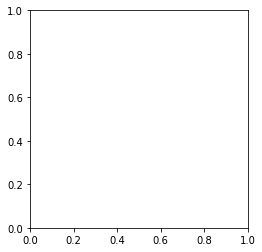

In [111]:
plt.imshow(img_fake)
plt.show()